In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datajoint as dj
import rf, pre, psy

DataJoint 0.2.1 (June 1, 2016)
Loading local settings from /Users/dimitri/.datajoint_config.json


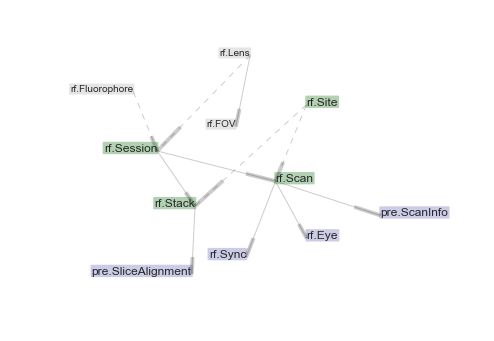

In [2]:
(dj.ERD(rf)+1).draw()

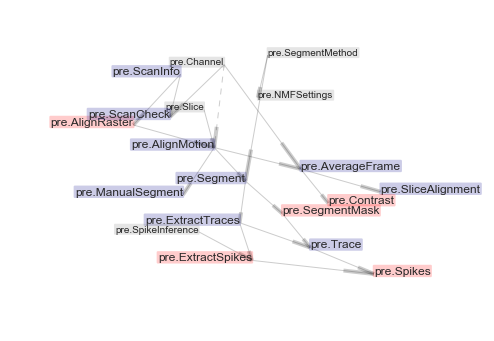

In [3]:
dj.ERD(pre).draw()

In [2]:
pre.AverageFrame().heading

animal_id            : int(11)                      # id (internal to database)
session              : smallint(6)                  # session index
scan_idx             : smallint(6)                  # number of TIFF stack file
slice                : tinyint(4)                   # slice number
channel              : tinyint(4)                   # channel number 1=green, 2=red'
frame                : longblob                     # motion aligned and computed as q-norm to approximate maximum projection

In [2]:
a = pre.AverageFrame() & 'animal_id=8623' & 'slice=3' & 'scan_idx=6' & 'channel=1'

In [3]:
pre.ScanInfo()

animal_id,session,scan_idx,nframes_requested,nframes,px_width,px_height,um_width,um_height,bidirectional,fps,zoom,dwell_time,nchannels,nslices,slice_pitch,fill_fraction
8341,1,4,27500,27500,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,6,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,7,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,8,26700,18000,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,9,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,10,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867
8341,1,11,26700,26700,256,256,400.0,400.0,1,14.6681,2.1,0.177018,2,3,7.0,0.712867


In [1]:
plt.imshow(a.fetch1['frame'], cmap=plt.cm.gray)

NameError: name 'plt' is not defined

In [ ]:
a = pre.Trace()*rf.Scan().proj('depth') & (rf.Sync() * psy.MovingNoise()) & 'depth>300' & 'slice=3'

In [ ]:
@pre.schema
class Contrast(dj.Computed):
    definition = """
    -> AverageFrame
    --- 
    contrast : double   # fake quantity
    """
    
    def _make_tuples(self, key):
        frame = (pre.AverageFrame() & key).fetch1['frame']
        key['contrast'] = frame.max()/frame.min()
        self.insert1(key)
        print('.', end='', flush=True)

In [ ]:
(dj.ERD(Contrast)-1+1-1+1).draw()

In [ ]:
Contrast().populate('animal_id=8623', 'channel=1')

In [ ]:
Contrast().progress();

In [ ]:
Contrast().progress('animal_id=8623', 'channel=1');

In [ ]:
Contrast()

In [ ]:
sns.distplot(Contrast().fetch['contrast'])

In [ ]:
sns.lmplot('depth','contrast', data=pd.DataFrame((Contrast()*rf.Scan()).fetch()))

In [ ]:
Contrast().drop()

In [ ]:
pre.Trace()

In [ ]:
pre.Trace()*pre.Spikes()*rf.Sync()

In [ ]:
pre.Trace()*pre.Spikes()*rf.Sync() & psy.MovingNoise() & (rf.Scan() & 'depth>300') & 'slice=3' & 'spike_inference=3'

In [ ]:
a = pre.Trace()*pre.Spikes()*rf.Sync() & psy.MovingNoise() & (rf.Scan() & 'depth>300') & 'slice=3' & 'spike_inference=3'
a.heading

In [ ]:
a.make_sql()

In [ ]:
# fetch image and mask data for a single cell
a &= dict(mask_id=13, spike_inference=3)
mask = pre.AverageFrame() * pre.SegmentMask() & a & 'channel=1'
frame, mask_px, mask_w = mask.fetch1['frame','mask_pixels','mask_weights'] 

# plot image and mask 
with sns.axes_style('white'):
    fig, ax = plt.subplots()
img = frame.ravel()*np.NaN
img[mask_px.astype(int).squeeze()] = mask_w.squeeze()
img = img.reshape(frame.shape)
ax.imshow(np.sqrt(frame), cmap=plt.cm.get_cmap('gray'))
ax.imshow(img.T, alpha=1, cmap=plt.cm.get_cmap('magma'))


In [ ]:
# fetch 
traces = np.hstack(a.fetch['ca_trace'])

# save 
pd.DataFrame(traces).to_csv('my_traces.csv',index=False)

In [ ]:
%matplotlib notebook

# fetch trace and trial data
times, traces, spikes = a.fetch1['frame_times', 'ca_trace','spike_trace']
trial_times = (psy.Trial() * a & 'trial_idx between first_trial and last_trial').fetch['flip_times']

# plot traces against time
trial_times = np.asarray([r[0,0] for r in trial_times])
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(times[0,::3]- times[0,0], traces, label='Ca Trace')
ax[1].plot(times[0,::3]- times[0,0], spikes, label='Spike Rate')
ax[0].set_ylabel('Fluorescence')
ax[1].set_ylabel('inferred spike rate')
ax[1].set_xlabel('time [s]')
ax[1].plot(trial_times - times[0,0], 0*trial_times+4,'h',color=sns.xkcd_rgb['greenblue'],ms=5)
sns.despine(fig)
fig.tight_layout()
